<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/11_diff_in_diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata
import statsmodels.formula.api as sm
import statsmodels.api as smp
from scipy.stats import ttest_1samp

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

In [ ]:
#
sql = """
SELECT
  event_date, platform,
  SUM(cnt_view_advertisement) cnt_view_advertisement_1,
  SUM(cnt_display_phone + cnt_send_message) as contact,
  SUM(cnt_display_phone + cnt_send_message) / SUM(cnt_view_advertisement) as cr
FROM
  hardda.user_dm_events
WHERE event_date BETWEEN '2022-01-01' AND '2022-06-07'
GROUP BY
  platform, event_date
ORDER BY
  platform, event_date
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
data.columns = ['event_date', 'platform', 'cnt_view_advertisement', 'contact', 'cr']

In [ ]:
data.event_date = pd.to_datetime(data.event_date, format='%Y-%m-%d')

In [ ]:
data.head()

,event_date,platform,cnt_view_advertisement,contact,cr
0,2022-02-01,android,1946760,99032,0.050870
1,2022-02-02,android,1936104,98353,0.050799
2,2022-02-03,android,1890293,98558,0.052139
3,2022-02-04,android,1810075,95222,0.052607
4,2022-02-05,android,1792061,92362,0.051540


## Задание 1 (1/2) ##

Какая средняя сумма контактов за день по платформе Android?

In [ ]:
android_contacts_mean = data.query('platform == "android"').contact.mean()
print(f"средняя сумма контактов за день по платформе Android = {android_contacts_mean:.0f}")

средняя сумма контактов за день по платформе Android = 94378


 ## Задание 1 (2/2) ##


Какая средняя сумма просмотров за день по платформе iOS?

In [ ]:
ios_view_mean = data.query('platform == "ios"').cnt_view_advertisement.mean()
print(f"средняя сумма контактов за день по платформе iOS = {ios_view_mean:.0f}")

средняя сумма контактов за день по платформе iOS = 536590


## Задание 2 ##

Постройте график динамики метрики в разрезе платформ и визуально посмотрите на динамику до и после изменения, введенного 2022-06-01.

Можно ли сделать вывод о динамике изменения метрики после intervention?

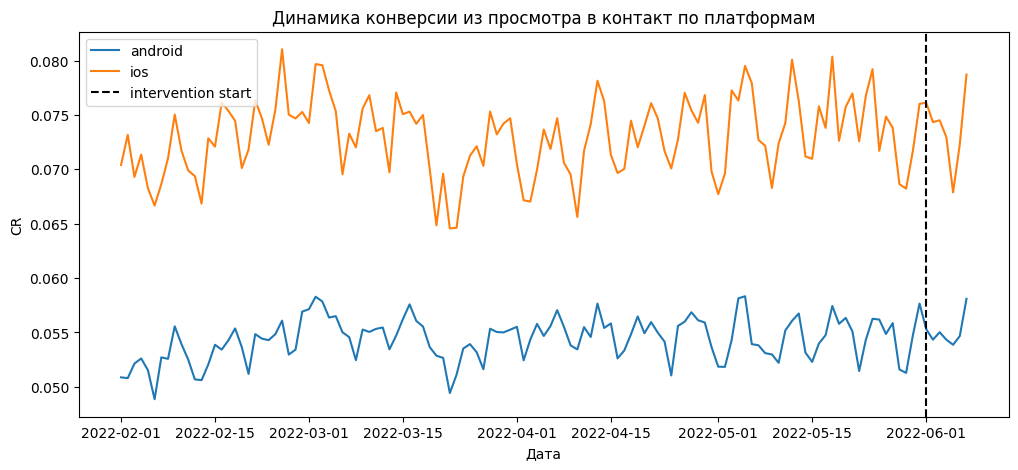

In [ ]:
intervention_date = pd.to_datetime('2022-06-01')
fig, axes = plt.subplots(figsize=(12, 5))
sns.lineplot(data=data, x='event_date', y='cr', hue='platform')
axes.axvline(intervention_date, color='black', ls = '--', label="intervention start")
axes.set_title('Динамика конверсии из просмотра в контакт по платформам')
axes.set_xlabel('Дата')
axes.set_ylabel('CR')
plt.legend()

In [ ]:
print("В данных наблюдается большая дисперсия, делать какие-то выводы 'на глаз' нельзя")

В данных наблюдается большая дисперсия, делать какие-то выводы 'на глаз' нельзя


## Задание 3 (1/2) ##

Оцените, параллельны ли тренды с помощью Критерия Дики-Фуллера.

Укажите среднюю разницу между рядами на pre периоде.

Введите значение в поле ниже с точностью до трех знаков в десятичной части.

In [ ]:
diff_df = data.query('event_date < "2022-06-01"').pivot(index='event_date', columns='platform', values='cr').diff(axis=1)['ios']
mean_diff = diff_df.mean()
mean_diff

0.01861212257583366

In [ ]:
print(f"Средняя разница между рядами на pre периоде = {mean_diff:.3f}")

Средняя разница между рядами на pre периоде = 0.019


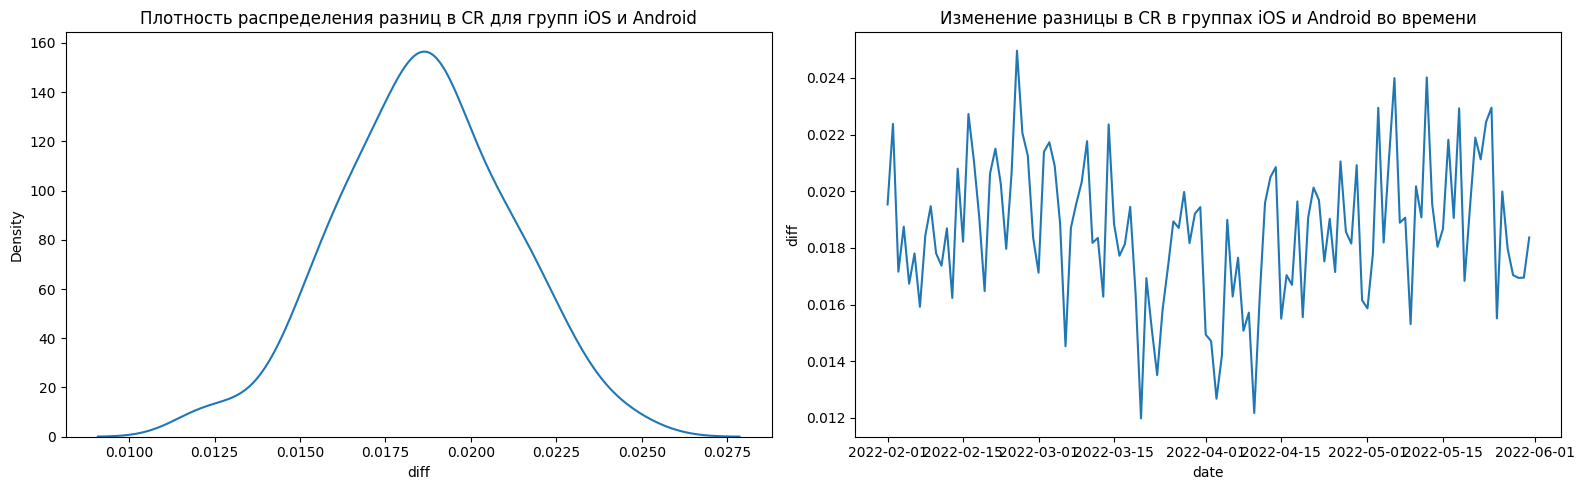

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
sns.kdeplot(diff_df, ax=axes[0])
sns.lineplot(data=diff_df, ax = axes[1])
axes[0].set_title('Плотность распределения разниц в CR для групп iOS и Android')
axes[0].set_xlabel('diff')

axes[1].set_title('Изменение разницы в CR в группах iOS и Android во времени')
axes[1].set_xlabel('date')
axes[1].set_ylabel('diff')
plt.tight_layout()

In [ ]:
# H0 - ряд нестационарен
# H1 - ряд стационарен

In [ ]:
diff_df = data.query('event_date < "2022-06-01"').pivot(index='event_date', columns='platform', values='cr').diff(axis=1)['ios']
pval = smp.tsa.stattools.adfuller(diff_df)[1]

In [ ]:
print("Тренды параллельны" if pval < 0.05 else "Тренды непараллельны")

Тренды параллельны


## Задание 4 (1/3) ##


Проанализируйте изменения с Diff-in-Diff с контрольной группой android. Отвергается ли нулевая гипотеза?

In [ ]:
df = data.copy()
df['intervention'] = np.where(df['event_date'] >= '2022-06-01', 1, 0)
df['treatment'] = np.where(df['platform'] == 'android', 1, 0)
df.reset_index(inplace=True)
df = df[['cr', 'intervention', 'treatment']]
df.head()

,cr,intervention,treatment
0,0.050870,0,1
1,0.050799,0,1
2,0.052139,0,1
3,0.052607,0,1
4,0.051540,0,1


In [ ]:
model = sm.ols(formula='cr ~ treatment + intervention + intervention:treatment', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     905.7
Date:                Wed, 17 Jul 2024   Prob (F-statistic):          6.06e-134
Time:                        10:43:58   Log-Likelihood:                 1130.4
No. Observations:                 254   AIC:                            -2253.
Df Residuals:                     250   BIC:                            -2239.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

intervention:treatment   pval = 0.891

Отвергнуть H0 нельзя. Влияние treatment не доказано

## Задание 4 (2/3) ##


Укажите, чему равно абсолютное изменение Diff-in-Diff.

Введите значение в поле ниже с точностью до пяти знаков в десятичной части.

In [ ]:
diff_in_diff = df.pivot_table(index='intervention', columns='treatment', values='cr', aggfunc='mean').diff(axis=1).diff().round(5)[1][1]

In [ ]:
print(f"абсолютное изменение Diff-in-Diff = {np.abs(diff_in_diff)}")

абсолютное изменение Diff-in-Diff = 0.00013


In [ ]:
# также Diff-in-Diff можно пролучить из модели
model.params['intervention:treatment']

-0.0001329724411572586

## Задание 5 (1/2) ##


Проведите симуляцию ошибок I и II рода для эффектов [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1], где 1 — нет эффекта.

Используйте следующие параметры для симуляции:

ковариата — 'android'
n_days = 7
control_percent = 0.7
n_sim = 100,
random_state в функции оставляем без изменений.
Укажите ошибку II рода для эффекта минус 5%.

Введите значение в поле ниже с точностью до двух знаков в десятичной части.

In [ ]:
import joblib

Подготовим функции для удобного симулирования pre post разбивки на исторических данных. Фиксируя определенный процент для исторических данных, рандомно подбирая даты из остальной части, задаем синтетические эффекты и проводим анализ Diff-in-Diff:

In [ ]:
def causal_analysis(data, control_group, n_days = 14, control_percent = 0.7, sample_n = 100):
    '''
    data ― наши исторические данные, на которых мы будем прогонять проверку критерия
    control_group ― название переменной, формирующей контрольную группу
    n_days ― количество дней тестового периода, то есть сколько мы предполагаем будет идти пост-период в днях. Задавать нужно так, чтобы размер n_days не превышал 1-control_percent долю тестовых данных. Поэтому процент 1-control_percent нужно оставлять с запасом. Оптимальный размер ― 3-4 недели
    control_percent ― доля исторических данных, которую мы резервируем для контрольного периода. Например, не меньше 70%. Где-то в промежутке после этого будет появляться Intervention
    sample_n ― количество симуляций. Сколько раз прогоняем на каждый проверяемый эффект симуляции (в коде по умолчанию 7 эффектов)
    '''
    n_days -= 1

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # Эффекты от снижения до увеличения. 1 - эффекта нет = АА вариант
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # Самая первая дата контрольной группы
    initial = dates.values[0][0]
    # Тестовая группа, подбираем из неё sample_n рандомных дат в тестовом периоде, т.е. sample_n дат после control_percent дней.
    # мы как бы рандомно накидываем дни старта нововведения в тестовой зоне
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\

    # Определяем пост и пре период в зависимости от полученных рандомных дат в тестовом периоде
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            # формируем датасеты для оценки эффектов, добавляем нужные эффекты
            df_copy = data.copy() # создаем другую переменную дубликата датафрейма, чтобы каждый раз задавать новый эффект

            # указываем, когда был intervention
            df_copy['intervention'] = 0
            df_copy.loc[post_period[0]:post_period[1], 'intervention'] = 1

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), 'y'] *= effects[i] # задаем эффект

            df_copy = pd.melt(df_copy.reset_index(), id_vars = ['index', 'intervention'], value_vars = ['y', control_group],
                 var_name = 'variable', value_name = 'value')
            df_copy['treatment'] = np.where(df_copy.variable == 'y', 1, 0)

            formula = 'value ~ treatment + intervention + treatment * intervention'
            model = sm.ols(formula = formula, data = df_copy)
            res = model.fit()

            b0 = res.params['Intercept']
            b1 = res.params['treatment']
            b2 = res.params['intervention']
            b3 = res.params['treatment:intervention']

            # Понимая как устроен Diff-in-Diff, можем с регрессии вычислить относительное изменение diff-in-diff
            rel_diff_in_diff = ((b0 + b1 + b2 + b3) / (b0 + b1)) / ((b0 + b2) / b0) - 1

            real_eff = effects[i] - 1
            to_sse = pow(rel_diff_in_diff - real_eff, 2) # считаем квадрат ошибок нашего найденного diff-in-diff и реального
            to_mape = abs(rel_diff_in_diff - real_eff) * 100 # считаем среднюю абсолютную ошибку в процентах

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(rel_diff_in_diff)
            p_vals.append(res.pvalues['treatment:intervention'])

        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['control_group'] = control_group
    return final

Напишем функцию, которая удобно агрегирует результаты симуляций

In [ ]:
def to_res(data, to_group, n, alpha = 0.05): # Указываем уровень значимости = 0.05
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha) # Подсчет ошибки I рода

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha) # Подсчет ошибки II рода

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum', # Sum of Squared Errors
                                     'mape': 'mean', # Mean Absolute Percentage Error
                                     p_val_cols[0]: p_val_count_alpha, # Ошибка I рода в количестве
                                     p_val_cols[1]: p_val_count_beta, # Ошидка II рода в количестве отсюда и дальше по эффектам
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n # Делим на количество симуляции = 50
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

In [ ]:
diff_df = data.query('event_date < "2022-06-01"').pivot(index='event_date', columns='platform', values='cr')

In [ ]:
diff_df.columns = ['android', 'y']
diff_df.index.name = None

In [ ]:
diff_df

,android,y
2022-02-01,0.050870,0.070403
2022-02-02,0.050799,0.073174
2022-02-03,0.052139,0.069300
2022-02-04,0.052607,0.071356
2022-02-05,0.051540,0.068276
...,...,...
2022-05-27,0.055862,0.073830
2022-05-28,0.051593,0.068635
2022-05-29,0.051281,0.068223
2022-05-30,0.054716,0.071668


In [ ]:
n_days = 7
control_percent = 0.7
sample_n = 100

result = causal_analysis(diff_df, 'android', n_days=7, control_percent=0.7, sample_n=100)
result.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,control_group
0,2022-05-09,2022-05-15,2022-02-01,2022-05-08,0.000835,1.089934,0.662468,0.112052,0.470014,0.006419,0.060393,8.779439e-07,0.000035,android
1,2022-04-28,2022-05-04,2022-02-01,2022-04-27,0.000015,0.146702,0.979150,0.260363,0.237847,0.023516,0.019943,7.741925e-06,0.000005,android
2,2022-05-24,2022-05-30,2022-02-01,2022-05-23,0.000273,0.623444,0.778898,0.387609,0.153962,0.045615,0.010429,2.614566e-05,0.000002,android
3,2022-04-28,2022-05-04,2022-02-01,2022-04-27,0.000015,0.146702,0.979150,0.260363,0.237847,0.023516,0.019943,7.741925e-06,0.000005,android
4,2022-05-02,2022-05-08,2022-02-01,2022-05-01,0.003478,2.224939,0.256353,0.020521,0.952802,0.000510,0.209383,1.249233e-08,0.000306,android


In [ ]:
res_conc = to_res(result, 'control_group', n=sample_n)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
control_group,,,,,,,,,,
android,0.194715,1.443382,0.0,0.55,1.0,0.03,0.72,0.0,0.0,96 days 16:19:12


In [ ]:
print(f"Ошибка II рода для эффекта минус 5% = {res_conc.p_val_0_95[0]}")

Ошибка II рода для эффекта минус 5% = 0.72


## Задание 5 (2/2) ##


Какой будет оценка ошибки I рода?

Введите значение в поле ниже с точностью до одного знака в десятичной части.

In [ ]:
print(f"Ошибка I рода для эффекта минус 5% = {res_conc.p_val_1[0]}")

Ошибка I рода для эффекта минус 5% = 0.0
